# 🛍️ SmartCart Starter Notebook
This notebook will guide you through your group project on collaborative filtering and association rule mining for an e-commerce recommender system.

## 📥 Part 1: Data Preprocessing
Steps:
- Load `ecommerce_user_data.csv` and `product_details.csv`
- Merge data if necessary
- Create user-item matrix
- Fill missing ratings with 0
- Group user behavior by category

In [29]:
# Load data
import pandas as pd

user_data = pd.read_csv('ecommerce_user_data.csv')
product_data = pd.read_csv('product_details.csv')

print(user_data.head())
print(product_data.head())


  UserID ProductID  Rating   Timestamp  Category
0   U000     P0009       5  2024-09-08     Books
1   U000     P0020       1  2024-09-02      Home
2   U000     P0012       4  2024-10-18     Books
3   U000     P0013       1  2024-09-18  Clothing
4   U000     P0070       4  2024-09-16      Toys
  ProductID      ProductName     Category
0     P0000      Toys Item 0     Clothing
1     P0001  Clothing Item 1  Electronics
2     P0002     Books Item 2  Electronics
3     P0003  Clothing Item 3  Electronics
4     P0004  Clothing Item 4  Electronics


In [46]:
# Display DataFrame info
print(user_data.info())
print(product_data.info())

# Handle missing data

# Check for missing values
print("Missing values in user_data:\n", user_data.isnull().sum())
print("Missing values in product_data:\n", product_data.isnull().sum())

# Avoid chained assignment by using direct assignment instead of inplace=True
# Fill missing ratings with 0
user_data = user_data.copy()  # Optional: ensures user_data isn't a view
user_data['Rating'] = user_data['Rating'].fillna(0)

# Drop rows if UserID or ProductID is missing
user_data = user_data.dropna(subset=['UserID', 'ProductID'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 724 entries, 0 to 723
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   UserID     724 non-null    object
 1   ProductID  724 non-null    object
 2   Rating     724 non-null    int64 
 3   Timestamp  724 non-null    object
 4   Category   724 non-null    object
dtypes: int64(1), object(4)
memory usage: 28.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ProductID    100 non-null    object
 1   ProductName  100 non-null    object
 2   Category     100 non-null    object
dtypes: object(3)
memory usage: 2.5+ KB
None
Missing values in user_data:
 UserID       0
ProductID    0
Rating       0
Timestamp    0
Category     0
dtype: int64
Missing values in product_data:
 ProductID      0
ProductName    0
Category       0
dtype: int64

In [33]:
# Create user-item matrix
user_item_matrix = user_data.pivot_table(index='UserID', columns='ProductID', values='Rating')
user_item_matrix_filled = user_item_matrix.fillna(0)
user_item_matrix_filled.head()

ProductID,P0000,P0001,P0002,P0003,P0004,P0005,P0006,P0007,P0008,P0009,...,P0090,P0091,P0092,P0093,P0094,P0095,P0096,P0097,P0098,P0099
UserID,,,,,,,,,,,,,,,,,,,,,
U000,0.0,0.0,0.0,3.0,0.0,5.0,0.0,3.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U001,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
U002,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
U004,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0


In [48]:

# Aggregate user behavior by category
user_category_agg = user_data.groupby(['UserID', 'Category']).agg({'Rating': ['count', 'mean']}).reset_index()
user_category_agg.columns = ['UserID', 'Category', 'TotalInteractions', 'AverageRating']
user_category_agg.head()

,UserID,Category,TotalInteractions,AverageRating
0,U000,Books,6,3.666667
1,U000,Clothing,3,1.666667
2,U000,Electronics,3,3.666667
3,U000,Home,2,1.000000
4,U000,Toys,6,3.500000


## 🤝 Part 2: User-Based Collaborative Filtering
Steps:
- Use cosine similarity to compare users
- Recommend top-N products based on similar users
- Evaluate with Precision@K and Coverage

In [57]:
# Compute cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(user_item_matrix_filled)
user_similarity_df = pd.DataFrame(similarity_matrix, index=user_item_matrix_filled.index, columns=user_item_matrix_filled.index)
user_similarity_df.head()

UserID,U000,U001,U002,U003,U004,U005,U006,U007,U008,U009,...,U040,U041,U042,U043,U044,U045,U046,U047,U048,U049
UserID,,,,,,,,,,,,,,,,,,,,,
U000,1.000000,0.063071,0.195522,0.023466,0.065412,0.161251,0.160096,0.092083,0.238263,0.274844,...,0.241693,0.129483,0.156790,0.132200,0.161478,0.100346,0.126917,0.150727,0.000000,0.104294
U001,0.063071,1.000000,0.190861,0.000000,0.111332,0.009540,0.000000,0.172286,0.167460,0.017593,...,0.121540,0.024075,0.097953,0.007821,0.000000,0.000000,0.193670,0.247805,0.000000,0.000000
U002,0.195522,0.190861,1.000000,0.065094,0.111662,0.050830,0.027756,0.055877,0.000000,0.181229,...,0.144756,0.000000,0.217465,0.000000,0.055992,0.034794,0.194243,0.110030,0.177165,0.000000
U003,0.023466,0.000000,0.065094,1.000000,0.035737,0.104116,0.026650,0.000000,0.025384,0.288009,...,0.243836,0.000000,0.000000,0.074688,0.197121,0.000000,0.054396,0.126773,0.374228,0.250000
U004,0.065412,0.111332,0.111662,0.035737,1.000000,0.159064,0.057144,0.026294,0.195942,0.247023,...,0.062741,0.116202,0.078797,0.048044,0.103747,0.133716,0.124969,0.217464,0.255318,0.172729


In [59]:
# Create recommendation function

# Find most similar user, recommend products they rated highly that target user hasn’t rated

In [13]:
#Explanation:
#Step 1: The function retrieves the target user's ratings from the user‑item matrix.

# Step 2: It identifies which products the target user hasn't rated (where the rating is 0).

# Step 3: Using the cosine similarity DataFrame (similarity_df), the function finds the most similar user to the target (excluding the target themselves).

# Step 4: It then looks up the ratings of that most similar user, filters to include only the products that the target user hasn't rated, and sorts these products in descending order by the similar user's rating.

# Step 5: Finally, it returns the top‑N recommended products along with the ratings from the similar user.

In [61]:
def recommend_products_from_most_similar(user_id, user_item_matrix, similarity_df, top_n=5):
    """
    Recommend products for the target user based on the most similar user's ratings.
    
    Parameters:
      user_id (str): The target user's ID.
      user_item_matrix (DataFrame): User-item rating matrix with unrated items as 0.
      similarity_df (DataFrame): DataFrame containing cosine similarity scores between users.
      top_n (int): Number of recommendations to return.
      
    Returns:
      List of tuples: Each tuple contains (ProductID, rating from similar user).
    """
    # Get the target user's ratings
    target_ratings = user_item_matrix.loc[user_id]
    
    # Identify products the target user hasn't rated (assumed to be 0)
    unrated_products = target_ratings[target_ratings == 0].index

    # Get similarity scores for the target user, drop the target itself
    sim_scores = similarity_df.loc[user_id].drop(user_id)
    
    # Identify the most similar user (with the highest similarity score)
    most_similar_user = sim_scores.idxmax()
    
    # Get ratings of the most similar user
    similar_user_ratings = user_item_matrix.loc[most_similar_user]
    
    # Filter for products that the target user hasn't rated
    candidate_products = similar_user_ratings[similar_user_ratings > 0]
    candidate_products = candidate_products[candidate_products.index.isin(unrated_products)]
    
    # Sort the candidate products by the similar user's rating in descending order
    recommendations = candidate_products.sort_values(ascending=False)
    
    # Return top_n recommendations as a list of (ProductID, rating) tuples
    return list(recommendations.head(top_n).items())

# Example usage:
# Replace 'U001' with a valid user ID from your dataset.
user_id_example = 'U001'
recommendations = recommend_products_from_most_similar(user_id_example, user_item_matrix_filled, similarity_df, top_n=5)
print(f"Top Recommendations for {user_id_example} based on the most similar user:")
for product, rating in recommendations:
    print(f"Product {product}: Similar user's Rating {rating:.2f}")


Top Recommendations for U001 based on the most similar user:
Product P0046: Similar user's Rating 5.00
Product P0061: Similar user's Rating 5.00
Product P0064: Similar user's Rating 5.00
Product P0010: Similar user's Rating 4.00
Product P0067: Similar user's Rating 4.00


In [44]:
# Implement evaluation metrics like Precision@K and Coverage

# Example: compare recommended vs actual rated items

In [63]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Convert the Timestamp to datetime (adjust format if needed)
user_data['Timestamp'] = pd.to_datetime(user_data['Timestamp'])

# Split the data into training and testing sets based on a chosen cutoff date.
# Adjust the cutoff date based on your data distribution.
cutoff_date = pd.Timestamp('2024-10-01')
train_data = user_data[user_data['Timestamp'] < cutoff_date]
test_data = user_data[user_data['Timestamp'] >= cutoff_date]

# Create the user-item matrix from training data.
train_matrix = train_data.pivot_table(index='UserID', columns='ProductID', values='Rating', fill_value=0)


# Define a function to predict ratings for items a user has not rated.
def predict_ratings_for_user(user_id, train_matrix, user_similarity_df, top_similar=5):
    # Select the top 'top_similar' most similar users (exclude the user itself)
    similar_users = user_similarity_df[user_id].drop(user_id).nlargest(top_similar).index
    weights = user_similarity_df[user_id].loc[similar_users]
    
    # Ratings of similar users
    similar_ratings = train_matrix.loc[similar_users]
    
    # Compute weighted sum of ratings for each item
    weighted_ratings = similar_ratings.mul(weights, axis=0).sum(axis=0)
    
    # Normalize by the sum of weights
    predicted_ratings = weighted_ratings / weights.sum()
    
    # Remove items the user has already rated in training data.
    already_rated = train_matrix.loc[user_id] > 0
    predicted_ratings = predicted_ratings[~already_rated]
    
    # Return predicted ratings sorted in descending order.
    return predicted_ratings.sort_values(ascending=False)

# Generate recommendations for each user in the training set.
# Here, we obtain the top 10 items for each user.
recommendations = {}
for user in train_matrix.index:
    preds = predict_ratings_for_user(user, train_matrix, user_similarity_df, top_similar=5)
    recommendations[user] = preds.index.tolist()[:10]

# Build ground truth from the test set.
# Define “relevant” items as those where the rating meets or exceeds a given threshold.
relevance_threshold = 3  # Adjust this threshold based on your evaluation criteria.
ground_truth = (test_data[test_data['Rating'] >= relevance_threshold]
                .groupby('UserID')['ProductID']
                .apply(list)
                .to_dict())

# Define a function to compute Precision@K for one user.
def precision_at_k(recommended, relevant, k):
    recommended_at_k = recommended[:k]
    relevant_set = set(relevant)
    num_relevant = sum(1 for item in recommended_at_k if item in relevant_set)
    return num_relevant / k

# Compute average Precision@K across users.
k_value = 10  # You can change this to any desired cutoff.
precision_scores = []
for user, rec_items in recommendations.items():
    if user in ground_truth:
        precision_scores.append(precision_at_k(rec_items, ground_truth[user], k_value))

if precision_scores:
    avg_precision = np.mean(precision_scores)
    print("Average Precision@{}: {:.4f}".format(k_value, avg_precision))
else:
    print("No ground truth available for evaluation.")

# Compute Coverage.
# This is the fraction of unique items recommended out of the total items in your product catalog.
total_items = set(product_data['ProductID'])
recommended_items = set(item for rec_list in recommendations.values() for item in rec_list)
coverage = len(recommended_items) / len(total_items)
print("Coverage: {:.4f}".format(coverage))


Average Precision@10: 0.1673
Coverage: 0.8600


## 🔍 Part 3: Association Rule Mining (Apriori)
Steps:
- Convert user-product interactions to transaction format
- Apply Apriori algorithm to find frequent itemsets
- Generate association rules (support, confidence, lift)

In [66]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [68]:
# Convert to transaction format

from mlxtend.preprocessing import TransactionEncoder
transactions = user_data.groupby('UserID')['ProductID'].apply(list).tolist()
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)

In [70]:
# Apply Apriori and generate rules
from mlxtend.frequent_patterns import apriori, association_rules
frequent_itemsets = apriori(df_trans, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5)
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head()

,antecedents,consequents,support,confidence,lift
0,(P0000),(P0008),0.06,0.500000,2.777778
1,(P0000),(P0023),0.06,0.500000,3.125000
2,(P0000),(P0030),0.06,0.500000,2.272727
3,(P0000),(P0071),0.06,0.500000,2.777778
4,(P0091),(P0001),0.08,0.571429,3.174603


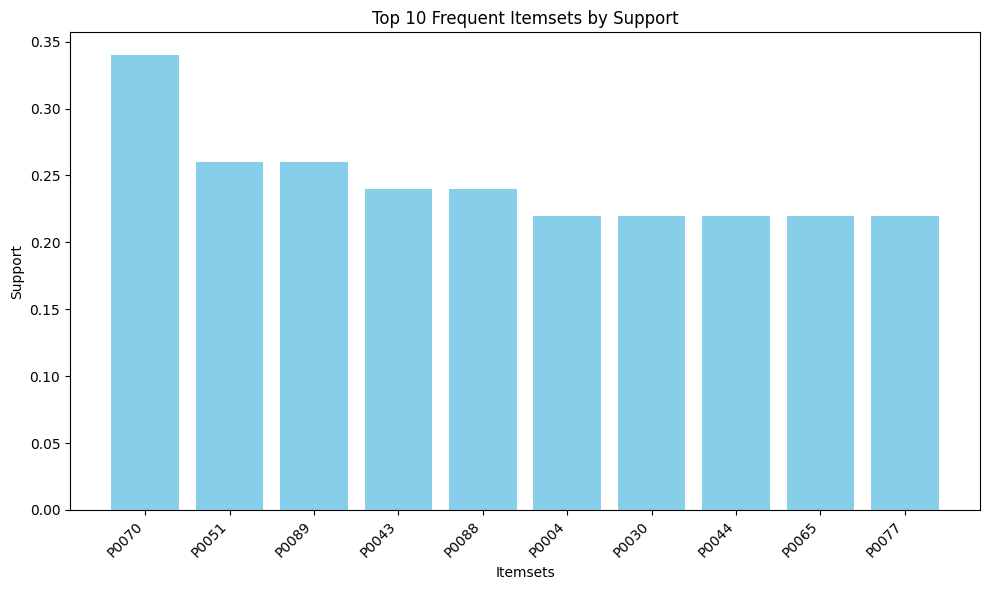

In [72]:
import matplotlib.pyplot as plt

# Sort frequent_itemsets by support and select the top 10
top_itemsets = frequent_itemsets.nlargest(10, 'support')

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_itemsets)), top_itemsets['support'], color='skyblue')
plt.xticks(
    range(len(top_itemsets)),
    [', '.join(list(x)) for x in top_itemsets['itemsets']],  # Convert each frozenset to a string
    rotation=45,
    ha='right'
)
plt.xlabel('Itemsets')
plt.ylabel('Support')
plt.title('Top 10 Frequent Itemsets by Support')
plt.tight_layout()
plt.show()


## 📊 Part 4: Visualization
Steps:
- Plot user similarity heatmap
- Plot top frequent itemsets
- Visualize top recommendations

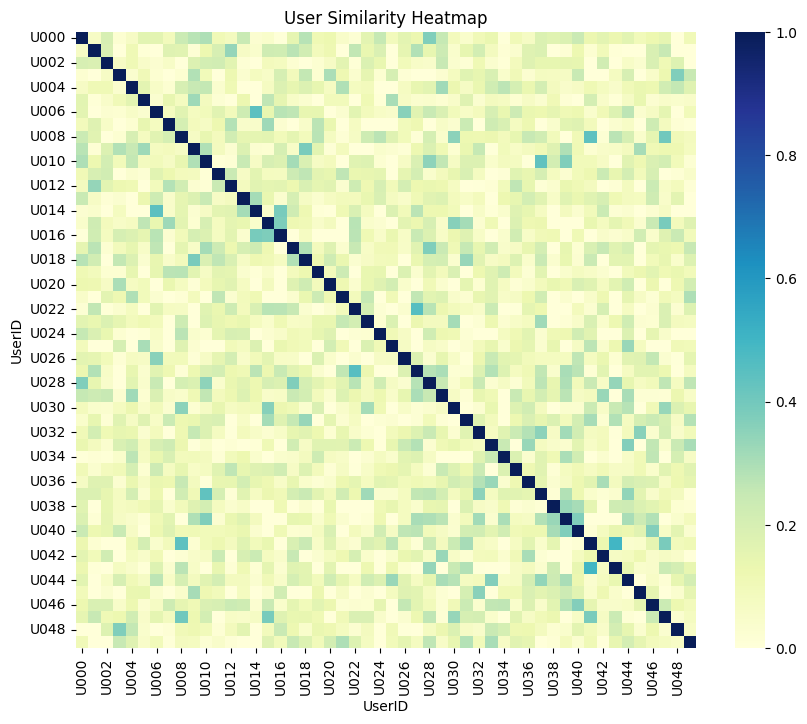

In [75]:
# Heatmap of user similarity
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, cmap='YlGnBu')
plt.title('User Similarity Heatmap')
plt.show()

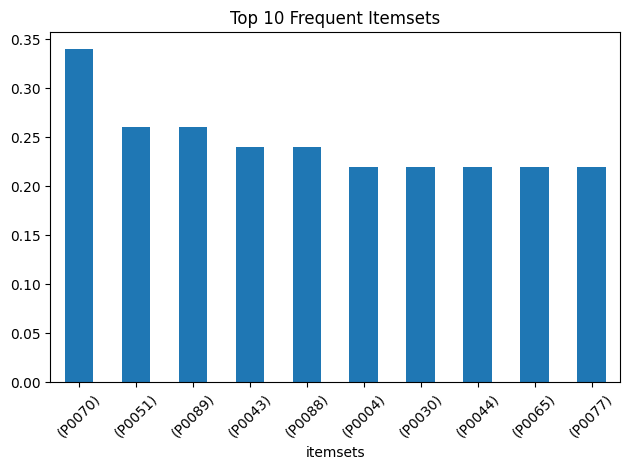

In [77]:
# Frequent itemsets bar chart
frequent_itemsets.nlargest(10, 'support').plot(kind='bar', x='itemsets', y='support', legend=False)
plt.title('Top 10 Frequent Itemsets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [79]:
# running the following block will open anothe page that shows a dashboard for the : • Top-5 product recommendations for each user group.

In [83]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

# ----- Compute User Groups -----
# Compute each user's group as their most frequently interacted product category.
user_groups = train_data.groupby('UserID')['Category'].agg(lambda x: x.mode().iloc[0])
user_groups = user_groups.to_dict()  # e.g., {UserID: category}

# ----- Aggregate Recommendations by User Group -----
# For each user in your recommendations, assign their group and aggregate their recommended products.
group_recommendations = {}
for user, recs in recommendations.items():
    group = user_groups.get(user)
    if group is not None:
        group_recommendations.setdefault(group, []).extend(recs)

# ----- Compute Top-5 Recommendations per Group -----
top5_recommendations = {}
for group, rec_list in group_recommendations.items():
    # Count product frequencies and pick the top 5.
    rec_counts = pd.Series(rec_list).value_counts().head(5)
    df_top5 = rec_counts.reset_index()
    df_top5.columns = ['ProductID', 'Frequency']
    top5_recommendations[group] = df_top5

# ----- Visualization: Interactive Dashboard -----
def display_top5(group):
    print(f"Top-5 Recommendations for User Group: {group}")
    df = top5_recommendations[group]
    display(df)
    
    plt.figure(figsize=(8, 5))
    plt.bar(df['ProductID'], df['Frequency'], color='skyblue')
    plt.title(f"Top-5 Recommendations for {group}")
    plt.xlabel("ProductID")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Create a dropdown widget using the groups computed.
group_selector = widgets.Dropdown(
    options=list(top5_recommendations.keys()),
    description='User Group:'
)

# Create the interactive dashboard.
widgets.interact(display_top5, group=group_selector)


/Applications/anaconda3/lib/python3.12/site-packages/ipywidgets/widgets/interaction.py:44: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  from ipykernel.pylab.backend_inline import flush_figures


interactive(children=(Dropdown(description='User Group:', options=('Books', 'Toys', 'Beauty', 'Clothing', 'Ele…

<function __main__.display_top5(group)>

## 🧠 Part 5: Conceptual Questions
Answer the following questions in your report:
1. How does data sparsity affect performance?
2. What kinds of product bundles were discovered?
3. What improvements would you suggest for real-world deployment?